### Реализация алгоритмов фильтрации CMNF, square-root-CKF

Для демонстрации результатов работы условно-минимаксного нелинейного и кубатурного фильтров Калмана рассматривается задача оценки параметров движения тренировочного корабля Blue Lady, который представляет собой физическую модель танкера для перевозки сырой нефти в масштабе 1:24.

Характеристики объекта:

$l = 13.75[m]$ - длина;

$b = 2.38[m]$ - ширина;

$m = 22.934 \cdot 10^3[kg]$ - масса.

По условию задачи на корабль действует ветер со скоростью $U=2[m/s]$ и в направлении $0[rad]$ к оси $x_e$.

Движение корабля по поверхности воды рассматривается как движения твердого тела с тремя степенями свободы. Позиция корабля $(x,y)$ и курс корабля $\psi$ в горизонтальной плоскости в стационарной инерциальной системе отсчета $\left\{x_e, y_e\right\}$ представляются вектором $\eta = [x, y, \psi]^T$.

Вторая система координат $\left\{x_b, y_b\right\}$ связана с центром тяжести корабля, в которой скорости корабля представляются вектором $\nu = [u, v, r]^T$, где $u$ - продольная скорость корабля, $v$ - поперечная скорость (скорость сноса), $r$ - угловая скорость (скорость отклонения от курса).

Позиция корабля $(x,y)$ измеряется с помощью DGPS (Diffferential Global Positioning System), курс корабля $\psi$ измеряется гиро-компасом. Соответственно, система описывается с помощью 6-мерного вектора состояний, три компоненты которого составляют вектор $\eta = [x,y,\psi]^T$ и измеряются, а три остальных компоненты составляют вектор $\nu = [u,v,r]^T$ и оцениваются с помощью фильтров.

## Математическая модель системы

Уравнения движения корабля, согласно второму закону Ньютона, записываются следующим образом:
$$
m \overset{\cdot\cdot}{x} = X\\
m \overset{\cdot\cdot}{y} = Y\\
I_z\overset{\cdot\cdot}{\psi} = N,
$$
где $X$ и $Y$ - силы, действующие вдоль осей $x_b$  и $y_b$ соответственно, m - масса корабля, $I_z$ - момент инерции, действующий вдоль оси, перпедникуярной плоскости движения корабля и направленной вниз.

Все эти уравнения могут быть записан
в одной и той же форме 
$$
\dot{ \mathbf{x}} = A\mathbf{x} + B\mathbf{u}\\
\mathbf{y} = C\mathbf{x},
$$
где 
$$
A = \begin{pmatrix}
0 &\; 0\\
1 & \; 0 
\end{pmatrix}, \; 
B = \begin{pmatrix}
1\\0
\end{pmatrix}, \;
C = \begin{pmatrix}
0\; 1
\end{pmatrix}
$$, а векторы состояний $\mathbf{x}$ представляются следующим образом:
$$
\mathbf{x_1} = 
\begin{pmatrix}
u_x\\x
\end{pmatrix}, \; 
\mathbf{x_2} = 
\begin{pmatrix}
v_y\\y
\end{pmatrix} \;
\mathbf{x_3} = 
\begin{pmatrix}
r\\ \psi
\end{pmatrix},
$$
где $u_x = dx/dt, \, v_y = dy/dt, \, r = d \psi /dt$ , $\mathbf{u}$ - силы $X,\, Y$ и момент сил $N$ соответственно.

Вектор скоростей корабля в движущейся системе координат $\nu = [u,v,r]^T$ может быть вычислен с помощью скоростей, определенных в стационарной системе координат, с помощью матрицы поворота следующим образом :
$$
\nu = \begin{pmatrix}
u\\v\\r
\end{pmatrix} \, = \, 
\begin{pmatrix}
\cos{\psi} & \; \sin{\psi} & \; 0\\
-\sin{\psi} & \; \cos{\psi} & \; 0\\
0 & \; 0 & \; 1
\end{pmatrix} \cdot 
\begin{pmatrix}
u_x\\v_y\\r
\end{pmatrix}
$$

#### Значения сил, действующих на корабль

В статье отсутствует уточнение для выражений сил, действующих на тело, но предполагается, что любые воздействия на корабль производит только ветер и некоторая случайность, которая будет добавлена в уравнения динамики и наблюдений далее.

В рамках других работ, на которые представлены ссылки в данной статье, значения сил вычисляются с помощью заранее вычисленных коэффициентов и, при том, с учетом других параметров кораблей, которые участвуют в экспериментах. В силу этого, в рамках задачи предложим следующую модель, которая позволяет получить аналитические выражения сил $X$ и $Y$, действующих на судно, и принять нулевым суммарный момент сил $N$.

Пользуясь законом Бернулли, можно получить разность давлений, действующих на противоположные борты корабля, и, соответственно, вычислить проекции сил, действующих на корабль, на оси системы координат, связанной с кораблем.
Для расчетов примем высоту корабля равной половине его шщирины, то есть $c = b/2$.

Так, раскладывая вектор скорости вектра по проекциям в системе отсчета $\{x_b,y_b\}$ и переходя к относительным значениям скорости, можно получить следующие модули разности давлений вдоль координатных осей подвижной системы отсчета:
$$
x_b: \;  |\Delta p_{x_b}| = \frac{\rho (U * \cos{\psi} + u_x \sin{psi} - v_y \cos{\psi})^2}{2} \\
y_b : \; |\Delta p_{y_b}| = \frac{\rho (U * \cos{\psi} - u_x \cos{psi} - v_y \sin{\psi})^2}{2}
$$

Соответственно, модули проекций сил в системе координат $\left\{x_b,y_b\right\}$ имеют выражения:
 $$
 F_{x_b} = |\Delta p_{x_b}| b \cdot c \\
 F_{y_b} = |\Delta p_{y_b}| l \cdot c
 $$
 
Проекции этих сил $X, \, Y$ в рамках стационарной системы отсчета $\left\{x_e,y_e\right\}$ связаны с $F_{x_b}, \, F_{y_b}$ следующим преобразованием:
$$
\begin{pmatrix}
X\\Y
\end{pmatrix} = 
\begin{pmatrix}
|\cos{\psi}| & \; |\sin{\psi}|\\
|\sin{\psi}| & \; -|\cos{\psi}|
\end{pmatrix} \cdot 
\begin{pmatrix}
F_{x_b}\\F_{y_b}
\end{pmatrix}
$$

### Система динамики и наблюдений

Далее, в рамках модели в уравнения динамики и наблюдений вносятся зашумления следующим образом:
$$
\dot{ \mathbf{x}} = A\mathbf{x} + B\mathbf{u} + G \cdot \sqrt{Q}\cdot w(t)\\
\mathbf{y} = C\mathbf{x} + \sqrt{R} \cdot v(t),
$$ 
где $$ G_x = G_y = 
\begin{pmatrix}
1 & \; 0 \\
0 & \; 0.01
\end{pmatrix}\; 
Q_x = Q_y = \begin{pmatrix}
0.1 & \; 0\\
0 & \; 0.2
\end{pmatrix},
$$ где элементы матриц $Q_x$  и $Q_y$ имеют размерность $[m^2]$, $R_x = R_y = 0.01[m^2]$, а 
$$
G_{\psi} =\begin{pmatrix}
0.2 & \; 0\\
0 & \; 0.01
\end{pmatrix}, \; 
Q_{\psi} = I^{2x2},
$$ где элементы матрицы $Q_{\psi}$ имеют размерность $[\circ^2]$, $R_\psi = 0.1[\circ^2]$.

$w(t)$ - случайные шумы, компоненты которых независимы, приращения которых имеют стандартные гауссовские распределения, $v(t)$ - стандартные гауссовские случайные величины.

Рассмотрим 6-мерный вектор состояний системы $x = [u_x, x, v_y, y, r, \psi]^T$, $G = diag(G_x,G_y,G_{\psi}), Q = diag(Q_x, Q_y, Q_{\psi})$ - блочные диагональные матрицы, $R = diag(R_x, R_y, R_{\psi})$.
$u(x(t)) = [F_{x_b}, F_{y_b}, 0]^T$ - вектор сил и моментов в уравнении движения, $A_0 = diag(A,A,A)$ - блочная диагональная матрица.

$B_0 = \begin{pmatrix}
1 & \; 0 & \; 0\\
0 & \; 0 & \; 0\\
0 & \; 1 & \; 0\\
0 & \; 0 & \; 0\\
0 & \; 0 & \; 1\\
0 & \; 0 & \; 0
\end{pmatrix}$,
$C_0 = \begin{pmatrix}
0 & \; 1 & \; 0 & \; 0 & \; 0 & \; 0\\
0 & \; 0 & \; 0 & \; 1 & \; 0 & \; 0\\
0 & \; 0 & \; 0 & \; 0 & \; 1 & \; 0\\
\end{pmatrix}$

Таким образом, непрерывная система наблюдений в задаче задается следующим образом:
$$
\dot{x(t)} = A_0 \cdot x(t) + B_0 u(x(t)) + G \cdot \sqrt{Q} w(t)\\
y(t) = C_0 \cdot x(t) + \sqrt{R} v(t)
$$, где $w(t)$ - случайные шумы, $v(t) \sim \mathcal{N}(0, I^{3x3})$.

Переходя к дискретной системе наблюдений по методу Эйлера-Маруямы, мы получаем следующую дискретную систему наблюдений:

$$
x_k = (A_0 \cdot x_{k-1} + B_0 u(x_{k-1})) \cdot \delta + \sqrt{\delta} G \cdot \sqrt{Q} w_k, \, k \in \mathbb{N}, \; \pi_0(x) \sim \mathbb{N}(X_0, \delta GQG^T )\\
y_k = C_0 \cdot x_k + \sqrt{R} v_k, 
$$

где $X_0$ - вектор начального состояния $w_k \sim \mathcal{N}(0, I^{6x6}), v_k \sim \mathcal{N}(0, I^{3x3})$. 

В рамках задачи в статье не обозначено строгих начальных условий и условий измерения по времени, потому мы рассмотрим систему в следующих предположениях:

начальное состояние $X_0 = \left(0.1[m/s], 0[m], 0.05[m/s], 0[m], -0.05[rad/s], 0[rad] \,\right)^T$;

моделирование состояний проводится на отрезке времени $T = 50[s]$ с шагом по временной сетке $\delta = 0.001[s]$, наблюдения поступают в 1000 раз реже моделирования состояний, то есть каждую секунду.

In [1]:
import numpy as np
import scipy.stats as sp
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.integrate as integrate
import scipy.sparse.linalg as sl
plt.rcParams["figure.figsize"] = (14,7)
import os
import itertools as it
import warnings
warnings.filterwarnings("error")

Зададим начальные условия, все величины, представленные в градусах, будем переводить в радианы.

In [2]:
step = 0.001
T = 50
net = np.linspace(0, T, int(T/step)+1)
m = np.array([0.1, 0, 0.05, 0, -0.05, 0])
n = 1
mass = 22.931 * 10**3 #kg
U = 2 #m/s
rho_air = 1.2754 #kg/m^3
a = 13.75 #m - length
b = 2.38 #m - width
c = b/2 #m - height

In [3]:
A = np.array([[0, 0],[1, 0]])
O_2 = np.zeros((2,2))
C = np.array([0,1])
G_x = np.diag([1, 0.01])
G_y = np.copy(G_x)
G_psi = np.diag([0.2, 0.01]) 
Q_x = np.diag([0.1, 0.2])
Q_y = np.copy(Q_x)
Q_psi = np.eye(2) * (np.pi/180)**2
R_x = 0.01
R_y = 0.01
R_psi = 0.1 * (np.pi/180)**2

Задаем блочные матрицы.

In [4]:

B_0 = np.vstack([[1,0,0],
                [0,0,0],
                [0,1,0],
                [0,0,0],
                [0,0,1],
                [0,0,0]])
C_0 = np.vstack([np.hstack([C, np.zeros(4)]),
               np.hstack([np.zeros(2), C, np.zeros(2)]),
               np.hstack([np.zeros(4), C])])
Q_x0 = G_x @ np.sqrt(Q_x)
Q_y0= G_y @ np.sqrt(Q_y)
Q_psi0 = G_psi @ np.sqrt(Q_psi)
Q_0 = np.vstack([np.hstack([Q_x0, O_2, O_2]), 
               np.hstack([O_2, Q_y0, O_2]),
               np.hstack([O_2, O_2, Q_psi0])])
A_0 = np.vstack([np.hstack([A, O_2, O_2]),
                np.hstack([O_2, A, O_2]),
                np.hstack([O_2, O_2, A])])
R_0 = np.sqrt(np.diag([R_x, R_y, R_psi]))

Объявим функции для выражения сил, которые ветер создает в действии по координатным осям $x_b$ и $y_b$.

In [6]:
def F_x_b(state):
    res_x = rho_air * b * c / 2 * ((U * np.cos(state.T[5]) - np.cos(state.T[5]) * state.T[0] - np.sin(state.T[5]) * state.T[2])**2)
    return res_x

In [7]:
def F_y_b(state):
    res_y = rho_air * a * c/2 * ((U * np.sin(state.T[5]) + np.sin(state.T[5]) * state.T[0] - state.T[2] * np.cos(state.T[5]))**2)
    return res_y

In [8]:
def project_x_y_e(F_xb, F_yb, state):
        mas = np.array([state.T[5], F_xb, F_yb])
        ret = np.array([np.abs(np.cos(mas[0])) * mas[1] + np.abs(np.sin(mas[0])) * mas[2],
                        np.abs(np.sin(mas[0])) * mas[1] - np.abs(np.cos(mas[0])) * mas[2],
                      np.zeros(state.shape[0]) if len(state.shape) > 1 else 0])
        return ret.T

In [9]:
def non_linear(X):
    res = project_x_y_e(F_x_b(X), F_y_b(X), X)
    return res

Функции из уравнений динамики и наблюдений.

In [10]:
def a_t(X):
    return (A_0 @ X.T).T + 1.0/mass * (B_0 @ non_linear(X).T).T

In [11]:
def A_t(X):
    return (C_0 @ X.T).T

Генерация траекторий и наблюдений.

In [12]:
def generate_trajectories(n):
    X_state=[m]
    for _ in range(1,net.shape[0]):
        X_state.append(X_state[-1] + a_t(X_state[-1]) * step
                 + (np.sqrt(step) * Q_0) @ 
                    np.random.multivariate_normal(np.zeros(6), np.eye(6)))
    return np.array(X_state)

In [13]:
def generate_observations(X_state):
    Y = []
    for i in range(1, len(X_state)):
        Y.append(A_t(X_state[i]) + R_0 @ np.random.multivariate_normal(np.zeros(3), np.eye(3)))
    return np.array(Y)

## CMNF

#### Структура алгоритма CMNF описывается следующим образом:

Базовый прогноз $\alpha_k$ вычисляется по формуле $$
\begin{equation}
\alpha_k(\hat{X}(t_{k-1})) = X(t_k), \text{ где } X(t_k) = \hat{X}(t_{k-1}) + \int \limits_{t_{k-1}}^{t_k} a(X(s),s)ds
\end{equation},
$$

Базовая коррекция вычисляется по формуле 
$$
\gamma_k(\hat{X}_{k-1}, \beta_k(Y_k)) = Y_k - c_k(\alpha_k(\hat{X}(t_{k-1})), 0)
$$

Для блочного вектора $Q_k = col(X(t_k), \alpha_k(\hat{X}_{k-1}), \gamma_k(\hat{X}_{k-1}, \beta_k(Y_k)))$ блочные вектор средних и блочная матрица представляются следующим образом:
$$
m_k = E[Q_k] = \left[\begin{array} &m_k^X\\m_k^{\alpha}\\m_k^{\gamma}\end{array}\right], \; R_k = cov(Q_k, Q_k) = \left[\begin{array}
 &R_k^{XX} & R_k^{X\alpha} & R_k^{X\gamma}\\
R_k^{\alpha X}& R_k^{\alpha \alpha} & R_k^{\alpha \gamma}\\
R_k^{\gamma X} & R_k^{\gamma \alpha} & R_k^{\gamma \gamma}\end{array}\right]
$$

1) Начальные условия.

Моделируется выбора синтетического состояния $\left\{X_0^{(i)}\right\}_{i=\overline{1,N}}$.

Вычисляются $$\hat{X_0} = \frac{1}{N} \sum_{i=1}^{N}X_0^{(i)}, \;
\hat{K}_0^{XX}= \frac{1}{N-n}\sum_{i=1}^{N}\left(X_0^{(i)} - \hat{X_0}\right)\left(X_0^{(i)} - \hat{X_0}\right)^T.$$

$\hat{X_0}$ - целевая оценка фильтрации в начальный момент времени, $\hat{K}_0^{XX}$ - ковариационная матрица ошибки оценки фильтрации в начальный момент времени. Формируется выборка синтетических оценок фильтрации в начальный момент времени $\left\{\hat{X_0}^{(i)}\right\}_{i=\overline{1,N}}:\, \hat{X_0}^{(i)} \equiv \hat{X_0}.$
 

2) Шаг прогноза

Пусть на предыдущем шаге $k-1$ имеются оценка состояния $\hat{X_{k-1}}$, выборки синтетических состояний $\left\{X_{k-1}^{(i)}\right\}_{i=\overline{1,N}}$ и синтетических оценок фильтрации $\left\{
\hat{X}_{k-1}^{(i)}\right\}_{i=\overline{1,N}}$.

2.1) Методом Эйлера-Маруямы смоделировать решения СДС 
$$
dX(t) = a(X(t),t)dt \, + \, b(X(t),t)dw(t), \; X(0) = X_0 \sim \pi_0 (x)
$$
с начальными условиями $X(t_{k-1}) = X_{k-1}^{(i)}$, вычислить значения $ X(t_k, X_{k-1}^{(i)}) $, из которых впоследствии сформировать выборку синтетического состояния в момент времени $t_k$. 

2.2) По выборке $\left\{X_k^{(i)}\right\}_{i=\overline{1,N}}$ с помощью формулы $Y_k = c_k(X(t_k), W_k), \, t_l  k \Delta, \, k \in \mathbb{N},$  построить выборку синтетических наблюдений $\left\{Y_k^{(i)}\right\}_{i=\overline{1,N}}$

2.3) Вычислить выборки синтетических базовых прогнозов $\left\{\alpha_k(\hat{X}_{k-1}^{(i)})\right\}$ и синтетических базовых коррекций $\gamma_k(\hat{X}_{k-1}^{(i)}, \beta_k(Y_k^{(i)}))$

2.4) По пучку синтетических объектов 
$$\left\{
\begin{pmatrix}
X_k^{(i)}\\
\alpha_k(\hat{X}_{k-1}^{(i)})\\
\gamma_k(\hat{X}_{k-1}^{(i)}, \beta_k(Y_k^{(i)}))
\end{pmatrix}
\right\}
$$
построить выборочные моменты  $m_k, \, R_k$.

2.5) по целевой оценке фильтрации $\hat{X}_{k-1}$ в предыдущий момент времени $t_{k-1}$ и действительным наблюдениям $Y_k$, полученным в в момент времени $t_k$, вычислить целевой базовый прогноз $\alpha_k(\hat{X}_{k-1})$ и целевую базовую коррекцию $\gamma_k(\hat{X}_{k-1}, \beta_k(Y_k))$.

2.6) Модифицировать выборку синтетических прогнозов $\left\{\alpha_k(\hat{X}_{k-1}^{(i)})\right\}_{i=\overline{1,N}}$, по формуле 
$$
\check{X}_k = \bar{R}_k^{x\alpha}(\bar{R}_k^{\alpha \alpha})^+ \alpha_k(\hat{X}_{k-1}) + [m_k^x- \bar{R}_k^{\alpha \alpha}(\bar{R}_k^{\alpha \alpha})^+m_k^{\alpha}]
$$
получить выборку синтетических модифицированных прогнозов $\left\{\check{X}_k^{(i)}\right\}_{i=\overline{1,N}}$.

Модифицировать выборку синтетических базовых коррекций $\left\{\gamma_k(\hat{X}_{k-1}^{(i)}, \beta_k(Y_k^{(i)}))\right\}_{i=\overline{1,N}}$ по формуле 
$$
\check{\gamma}_k=\gamma_k(\hat{X}_{k-1}, \beta(Y_k)) - m_k^{\gamma} - \bar{R}_k^{\gamma \alpha}(\bar{R}_k^{\alpha \alpha})^+(\alpha_k(\hat{X}_{k-1})- m_k^{\alpha}),
$$
получить пучок синтетических модифицированных коррекций $\left\{\check{\gamma}_k^{(i)}\right\}_{i=\overline{1,N}}$

2.7)Модифицировать целевой базовый прогноз $\alpha_k(\check{X}_{k-1})$, получив целевой модифицированный прогноз $\check{X_k}$, модифицировать целевую базовую коррекцию $\gamma_k(\check{X}_{k-1}, \beta_k(Y_k))$, получив целевую модифицированную коррекцию $\check{\gamma}_k$.

3) Шаг коррекции

3.1) По выборке синтетических модифицированных объектов
$$\left\{
\begin{pmatrix}
\check{X}_k^{(i)}\\
\check{\gamma}_k^{(i)}
\end{pmatrix}
\right\}_{i=\overline{1,N}}
$$
построить выборку синтетических оценок филььтрации $\left\{\hat{X}_{k-1}^{(i)}\right\}_{i=\overline{1,N}}$по формуле $\hat{X}_k = \check{X}_l + \check{K}_k^{x \gamma} (\check{K}_k^{\gamma \gamma})^+\check{\gamma}_k$.

3.2) По выборке синтетических модифицированных объектов

$$
\begin{pmatrix}
\check{X}_k\\
\check{\gamma}_k
\end{pmatrix}
$$
построить оценку состояния $\hat{X}_k$ и ковариационную матрицу её ошибки $\hat{K}_k^{XX}$.

## Начальные условия

Поскольку в статье не задано начальное распределение $\pi_0(x)$, мы будем предполагать, что $\pi_0(x) = \mathcal{N}(x|m,\,  0.001 \cdot I^{6x6})$.

Реализация начальных условий

In [17]:
def initialize(N):
    X_init = np.random.multivariate_normal(m, step * Q_0 @ Q_0 @ np.eye(6), size = N)
    X0_synth_est = np.mean(X_init, axis=0)
    K_XX_0 = 1/(N-6) * np.sum((X_init - X0_synth_est[np.newaxis,:])[:,:,np.newaxis]
                              @ (X_init - X0_synth_est[np.newaxis,:])[:,np.newaxis], axis = 0)
    X0_synth_estimation_arr = np.repeat(X0_synth_est[np.newaxis,:], N, axis=0)
    return X0_synth_est, K_XX_0, X0_synth_estimation_arr, X_init

## Прогноз

Реализация 2.1

In [18]:
def euler_maruyama_step(X_synth_state, N):
    return X_synth_state + step * a_t(X_synth_state) + np.sqrt(step) * (Q_0 @ np.random.multivariate_normal(np.zeros(6),np.eye(6), size=N).T).T

Реализация 2.2

In [19]:
def generate_synth_observations(X_synth_state, N):
    return A_t(X_synth_state) + (R_0 @ np.random.multivariate_normal(np.zeros(3), np.eye(3), size=N).T).T

Реализация 2.3

Реализация $\alpha(\cdot)$

In [20]:
def synth_base_prognosis(X_synth_estimation):
    return  X_synth_estimation + a_t(X_synth_estimation) * step

Реализация $\gamma_k(\cdot)$

In [21]:
def synth_base_correction(Y_synth_observations, synth_prognosis):
    return Y_synth_observations - A_t(synth_prognosis)

Реализация 2.4

In [22]:
def sample_moments(X_synth_st, synth_prognosis, synth_correction):
    Q = np.hstack((X_synth_st, synth_prognosis, synth_correction))
    moments = np.mean(Q, axis=0)
    cov_mat = np.cov(Q.T)
    return moments, cov_mat

Реализация 2.6

In [23]:
def target_prognosis_correction(X_synth_est, Y, t1, t2):
    prognosis = synth_base_prognosis(X_synth_est, t1, t2)

    correction = synth_base_correction(Y, prognosis)
    return prognosis, correction

In [24]:
def modificate_synth_prognosis(synth_prognosis, R_xa, R_i, m_k):
    return (R_xa @ R_i @ synth_prognosis.T).T + m_k[:6] - R_xa @ R_i @ m_k[6:12]

def modificate_synth_correction(synth_prognosis, synth_correction, R_ga, R_i, m_k):
    return synth_correction - m_k[12:] - (R_ga @ R_i @ (synth_prognosis - m_k[6:12]).T).T

## Коррекция

Реализация 3.1

In [25]:
def calculate_synth_estimation(modified_prognosis, modified_correction, K_x_g, K_g_2):
    return modified_prognosis + (K_x_g @ np.linalg.pinv(K_g_2) @ modified_correction.T).T

## Алгоритм

In [84]:
def CMNF():
    X_estimated, K_estimated, X_synth_estimation, X_synth = initialize(500)
    X_res = [np.copy(X_estimated)]
    K_res = [np.copy(K_estimated)]
    
    for _ in range(0, net.shape[0]-1):
        #2.1
        X_synth = euler_maruyama_step(X_synth, 500)
        #2.2
        Y_synth = generate_synth_observations(X_synth, 500)
        #2.3
        alpha_synth = synth_base_prognosis(X_synth_estimation)
        gamma_synth = synth_base_correction(Y_synth, alpha_synth)
        #2.4
        m_k, R_k = sample_moments(X_synth, alpha_synth, gamma_synth)
        #2.5
        alpha_est = synth_base_prognosis(X_estimated)
        if _ % 1000 == 0:
            #В случае, если в данный момент наблюдение производится
            gamma_est = synth_base_correction(Y[_], alpha_est)
        #2.6
        R_alpha_2 = R_k[6:12, 6:12]
        R_x_alpha = R_k[:6, 6:12]
        R_gamma_alpha = R_k[12:, 6:12]
        R_alpha_gamma = R_k[6:12, 12:]
        R_inv = np.linalg.pinv(R_alpha_2)
        X_synth_estimation = modificate_synth_prognosis(alpha_synth, R_x_alpha, R_inv, m_k)
        gammas_modified = modificate_synth_correction(alpha_synth, gamma_synth, R_gamma_alpha, R_inv, m_k)
        #2.7
        X_predicted = modificate_synth_prognosis(alpha_est, R_x_alpha, R_inv, m_k)
        
        #В случае, если в данный момент наблюдение производится
        if _ % 1000 == 0:
            gamma_predicted = modificate_synth_correction(alpha_est, gamma_est, R_gamma_alpha, R_inv, m_k)
        #3.1
        K_x_gamma = R_k[:6, 12:] - R_x_alpha @ R_inv @ R_alpha_gamma
        K_gamma_2 = R_k[12:, 12:] - R_k[12:, 6:12] @ R_inv @ R_alpha_gamma
        K_inv = np.linalg.pinv(K_gamma_2)
        if _ %1000 == 0:
            #В случае, если в данный момент наблюдение производится
            X_synth_estimation = calculate_synth_estimation(X_synth_estimation, gammas_modified, K_x_gamma, K_gamma_2)
            #3.2                                                                          
            X_estimated = calculate_synth_estimation(X_predicted, gamma_predicted, K_x_gamma, K_gamma_2)
        else:
            X_estimated = X_predicted
        K_x_2 = R_k[:6,:6] - R_x_alpha @ R_inv @ R_k[6:12,:6]
        K_estimated = K_x_2 - K_x_gamma @ K_inv @ (K_x_gamma.T)
        
        X_res.append(np.copy(X_estimated))
        K_res.append(np.copy(K_estimated))
    return np.array(X_res), np.array(K_res)

## CKF (square root)

Представленная корневая версия алгоритма фильтрации CKF была взята из статьи ["Attitude determination method integrating square-root cubature Kalman filter with expectation-maximization for inertial navigation system applied to underwater glider"](https://aip.scitation.org/doi/pdf/10.1063/1.5110041) за авторством Haoqian Huang, Rengdu Shi и Jun Zhou.

Кубатурный фильтр Калмана CKF главным образом отличается от UKF тем, что приближенные вычисления инрегралов вида $\int \limits_{\mathbb{R}^N}f(x)\mathcal{N}(x,m,k)dx$ в нем производятся с помощью квадратур Гаусса-Эрмита, и, соответственно, множество сигма-точек представляет собой совокупность точек, построенных с ипользованием корней полинома Гаусса-Эрмита.

В N-мерном случае интегрирование производится следующим образом:
1) Вычисляются корни $x_i(i = \overline{1,n})$ полинома Гаусса-Эрмита $H_n(x) = (-1)^n e^{x^2}\frac{d^n}{dx^n}e^{-x^2}$порядка $n$ c с тем условием, чтобы количество точек в итоге было не меньше $N+1$.

2) Вычисляются веса полинома Гаусса-Эрмита порядка $n$ по формулам 
$$
w_i = \frac{2^{n-1}n!\sqrt{\pi}}{n^2(H_{n-1}(x_i))^2}
$$

3) Интеграл вычисляется по формуле 
$$
I = \int \limits_{\mathbb{R}^N}f(x)\mathcal{N}(x,m,k)dx  = \pi^{-N/2}\sum_{i_1=1}^{n}{\sum_{i_2=1}^{n}\ldots\sum_{i_N=1}^{n}{w_{i_1}w_{i_2}\ldots w_{i_N}f \left(k^{\frac{1}{2}}\left[\begin{matrix}x_{i_1}\\ \ldots \\ x_{i_N}\\ \end{matrix}\right]+
\left[\begin{matrix}m_1 \\ \ldots \\m_N \\ \end{matrix}\right]\right)}}.\ \ \ \ \ \ 
$$

Сам алгоритм представляется следующим образом:

1) Инициализация точек и весов

Для выбранного $n$  производится расчет множества весов $\left\{\omega_k = \frac{1}{(2 \pi)^{N/2}}w_{i_1}\cdot .. \cdot w_{i_N}\right\}$ мощностью $n^N, \, i_j = \overline{1,n}, \, j = \overline{1,N}$, где $w_{i_j}$ - один из весов полинома Гаусса-Эрмита степени $n$.

Производится расчет множства точек $\left\{\xi_k = [x_{i_1}, .. , x_{i_n}]^T\right\}$ в количестве $n^N$, где $x_{i_j}$ - корень полинома Гаусса-Эрмита степени $n$.

Инициализируется начальное значение оценки квадратного корня матрицы ковариации ошибок $\hat{S}_0 = \sqrt{cov(X_0,X_0)}$, $\hat{X_0} = X_0$.


2) Шаг прогноза

Пусть в момент времени k известна оценка состояния $\hat{X}_{k-1}$ в предыдущий момент времени и $S_{k-1}$.

2.1) Оценка множества кубатурных точек:

$$\left\{X_{i,k|k-1}\right\}_{i=\overline{1,n^N}} = \left\{S_{k-1} \cdot \xi_i + \hat{X}_{k-1}\right\}_{i=\overline{1,n^N}}.$$

2.2) Прогноз состояния: $\check{X_k} = \sum_{i=1}^{n^N} \omega_i \cdot a_t(X_{i,k|k-1})$

2.3) Оценка квадратного корня матрицы ковариации ошибок $\check{S_k} = Q([\chi_k, \, \sqrt{b_t}])$, где $Q(\cdot)$ - нижняя треугольная матрица в QR-разложении матрицы, а матрица $$\chi_{k|k-1} = 
\begin{bmatrix}
\sqrt{\omega_1}(X_{1,k|k-1} - \check{X_k})\\
\sqrt{\omega_2}(X_{2,k|k-1} - \check{X_k})\\
\ldots \\
\sqrt{\omega_{n^N}}(X_{n^N,k|k-1} - \check{X_k})
\end{bmatrix}^T$$

3) Коррекция

3.1) Коррекция множества кубатурных точек:

$$ \left\{X_{i,k|k}\right\}_{\overline{1,n^N}} = \left\{\check{S}_k \cdot \xi_i + \check{X}_k\right\}_{\overline{1,n^N}}$$

3.2) Коррекция наблюдения
$$\check{Y_k} = \sum_{i=0}^{n^N}w_i \cdot A_t(X_{i,k|k})$$

3.3) Коррекция квадратного корня матрицы ковариации ошибок:
$ \bar{S_k} = Q([\phi_k, \, \sqrt{B_t}])$, где 

$$
\phi_k = 
\begin{bmatrix}
\sqrt{\omega_1} (A_t(X_{1,k|k} - \check{Y_k}))\\
\sqrt{\omega_2} (A_t(X_{2,k|k} - \check{Y_k}))\\
\ldots\\
\sqrt{\omega_{n^N}}(A_t(X_{n^N,k|k} - \check{Y_k}))
\end{bmatrix}
$$

3.4) Вычисление матрицы кросс-ковариации 
$
\check{\mu}_k = \chi_k \cdot \phi_k^T,
$
$$где \chi_k = 
\begin{bmatrix}
\sqrt{\omega_1}(X_{1,k|k} - \check{X}_k)\\
\sqrt{\omega_2}(X_{2,k|k} - \check{X}_k)\\
\ldots\\
\sqrt{\omega_{n^N}}(X_{n^N,k|k} - \check{X}_k)
\end{bmatrix}$$

3.5) Коррекция оценки состояния: $$\hat{X}_k = \check{X}_k + \check{\mu}_k \cdot (\bar{S_k}\bar{S_k}^T)^{-1}\cdot(Y_k - \check{Y}_k)$$

3.6)Коррекция квадратного корня матрицы ковариации ошибок $\hat{S}_k = Q\left(\left[\chi_k - \check{\mu}_k \cdot (\bar{S}_k \bar{S}_k^T)^{-1} \cdot \phi_k, \; \check{\mu}_k \cdot (\bar{S}_k \bar{S}_k^T)^{-1} \cdot \sqrt{B_t}\right]\right)$

### Реализация алгоритма SR-CKF

In [32]:
def CKF():
    # Шаг 1:
    #Инициализация кубатурных точек и весов
    gauss_polynomial_order = 3
    H_points, H_weights = np.polynomial.hermite_e.hermegauss(gauss_polynomial_order)
    S_0 = np.copy(np.sqrt(step) * Q_0)

    indices = it.product(range(3), repeat = 6)
    X_pts = H_points[list(indices)]
    indices = it.product(range(3), repeat = 6)
    W_0 = 1 / (np.pi)**(3)* np.prod(H_weights[list(indices)], axis = 1)
    W_0 /= np.sum(W_0)
    #Инициализация начальных условий
    X_est_ckf = [m]
    K_est_ckf = [S_0]

    for i in range(0, X.shape[0]-1):
        #Шаг 2 - прогноз:
        #2.1
        S = K_est_ckf[-1]
        X_cub = (S @ X_pts.T).T + X_est_ckf[-1]
        #2.2
        X_prop = X_cub + step * a_t(X_cub)
        X_pred = W_0 @ X_prop
        #2.3
        S_pred = np.linalg.qr(np.hstack([(X_prop - X_pred).T * np.sqrt(W_0)[np.newaxis,:], np.sqrt(step) * Q_0]).T)[1].T
        #Шаг 3 = коррекция: если наблюдение присутствует в этот момент времени по условию 
        if i % 1000==0:
            #3.1
            X_cub = (S_pred @ X_pts.T).T + X_pred
            #3.2
            Y_prop = A_t(X_cub)
            Y_pred = W_0 @ Y_prop
            #3.3
            S_corr = np.linalg.qr(np.hstack([(Y_prop - Y_pred).T * np.sqrt(W_0)[np.newaxis,:], R_0]).T)[1].T
            #3.4
            mu_corr =  ((X_cub - X_pred).T * np.sqrt(W_0)[np.newaxis,:]) @ ((Y_prop - Y_pred) * np.sqrt(W_0)[:,np.newaxis])
            #3.5
            gain = mu_corr @ np.linalg.pinv(S_corr @ S_corr.T) #Вычисление gain - матрицы W_k в статье
            X_est = X_pred + gain @ (Y[i] - Y_pred)
            #3.6
            S_est = np.linalg.qr(np.hstack([(X_cub - X_pred).T * np.sqrt(W_0)[np.newaxis,:] -gain @ ((Y_prop - Y_pred).T * np.sqrt(W_0)[np.newaxis,:]),gain @ R_0]).T)[1].T
        else:
            X_est = X_pred
            S_est = S_pred
        X_est_ckf.append(np.copy(X_est))
        K_est_ckf.append(np.copy(S_est))
    return np.array(X_est_ckf), np.array(K_est_ckf)

## Демонстрация результатов

В силу вычислительной трудности будет произведена генерация траекторий и набюдений и их фильтрация на пучке из 500 траекторий, затем будут представлены графики компонент, их оценок и графики выборочных характеристик.

Генерируем траектории, осуществляем фильтрацию, сохраняем результаты в файлы.

In [33]:
s=0
try:
    for i in tqdm(range(n_traj)):
        X = generate_trajectories(1)
        Y = generate_observations(X)
        X_est_cmnf, K_cmnf = CMNF()
        X_est_ckf, S_ckf = CKF()
        np.save(f'/Users/Nikon/Desktop/Никонов/cmnf_{i}.npy', X_est_cmnf)
        np.save(f'/Users/Nikon/Desktop/Никонов/ckf_{i}.npy', X_est_ckf)
        np.save(f'/Users/Nikon/Desktop/Никонов/cov_cmnf_{i}.npy', K_cmnf)
        np.save(f'/Users/Nikon/Desktop/Никонов/cov_ckf_{i}.npy', S_ckf)
        np.save(f'/Users/Nikon/Desktop/Никонов/traj_{i}.npy', X)
except Exception:
    s+=1

100%|███████████████████████████████████████| 500/500 [9:10:04<00:00, 66.01s/it]

499


Производим ивзлечение данных из файлов, формируем массивы с результатами, которые будем использовать в дальнейшем.
Компоненты $u_x, v_y, r$ будем переводить в компоненты $u,v,r$ с помощью матрицы поворота. 

In [39]:
X = []
X_res_cmnf = []
K_res_cmnf = []
X_res_ckf = []
S_res_ckf = []
for i in tqdm(range(n_traj)):
    X_traj = np.load(f'/Users/Nikon/Desktop/Никонов/traj_{i}.npy')
    X_new = np.copy(X_traj)
    X_new[:,0] = np.cos(X_traj[:,5]) * X_traj[:,0] - np.sin(X_traj[:,5]) * X_traj[:,2]
    X_new[:,2] = np.sin(X_traj[:,5]) * X_traj[:,0] + np.cos(X_traj[:,5]) * X_traj[:,2]
    X.append(np.copy(X_new))
    
    X_est_cmnf = np.load(f'/Users/Nikon/Desktop/Никонов/cmnf_{i}.npy')
    X_est_cmnf_new = np.copy(X_est_cmnf)
    X_est_cmnf_new[:,0] = np.cos(X_est_cmnf[:,5]) * X_est_cmnf[:,0] - np.sin(X_est_cmnf[:,5]) * X_est_cmnf[:,2]
    X_est_cmnf_new[:,2] = np.sin(X_est_cmnf[:,5]) * X_est_cmnf[:,0] + np.cos(X_est_cmnf[:,5]) * X_est_cmnf[:,2]
    X_res_cmnf.append(np.copy(X_est_cmnf_new))
    
    K_res_cmnf.append(np.load(f'/Users/Nikon/Desktop/Никонов/cov_cmnf_{i}.npy'))
    
    X_est_ckf = np.load(f'/Users/Nikon/Desktop/Никонов/ckf_{i}.npy')
    X_est_ckf_new = np.copy(X_est_ckf)
    X_est_ckf_new[:,0] = np.cos(X_est_ckf[:,5]) * X_est_ckf[:,0] - np.sin(X_est_ckf[:,5]) * X_est_ckf[:,2]
    X_est_ckf_new[:,2] = np.sin(X_est_ckf[:,5]) * X_est_ckf[:,0] + np.cos(X_est_ckf[:,5]) * X_est_ckf[:,2]
    X_res_ckf.append(np.copy(X_est_ckf_new))
    
    S_res_ckf.append(np.load(f'/Users/Nikon/Desktop/Никонов/cov_ckf_{i}.npy'))
    
X = np.array(X)
X_res_cmnf = np.array(X_res_cmnf)
K_res_cmnf = np.array(K_res_cmnf)
X_res_ckf = np.array(X_res_ckf)
S_res_ckf = np.array(S_res_ckf)

100%|█████████████████████████████████████████| 500/500 [00:33<00:00, 14.95it/s]


### Визуализация

Сперва визуализируем полученные результаты.

Выведем графики исходных состояний и их оценок двумя полученными способами, интервал $+/-3\sigma$ вокруг оценки методом CMNF, а также график тривиальной оценки.

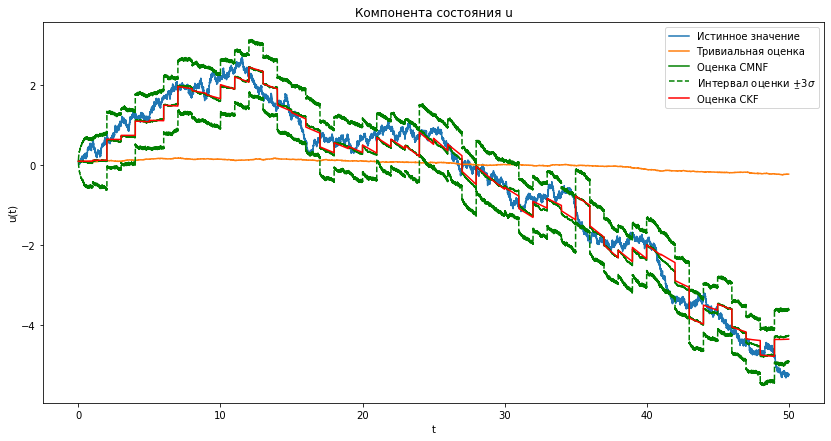

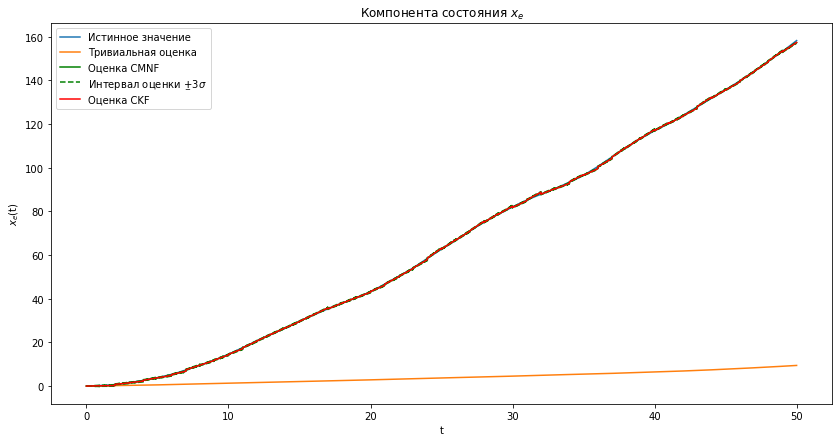

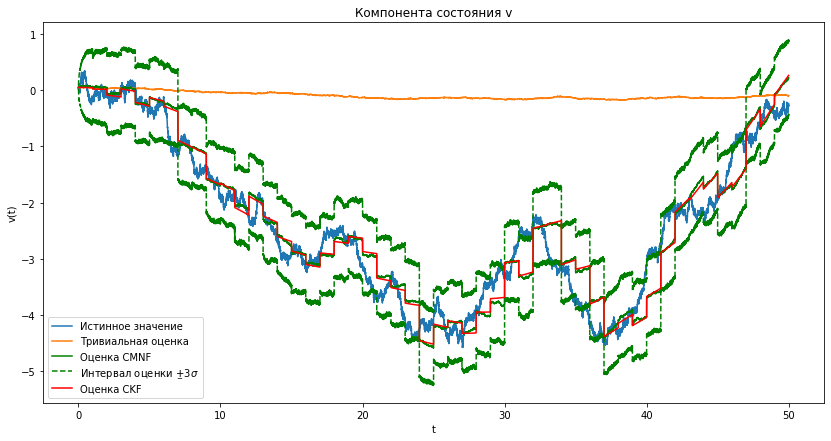

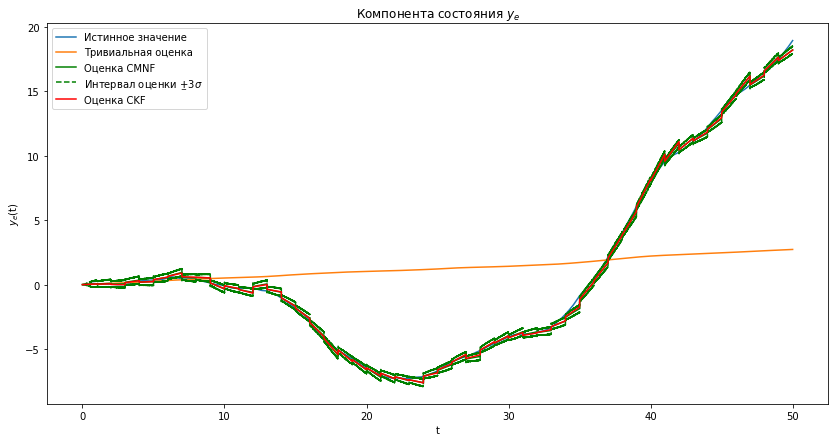

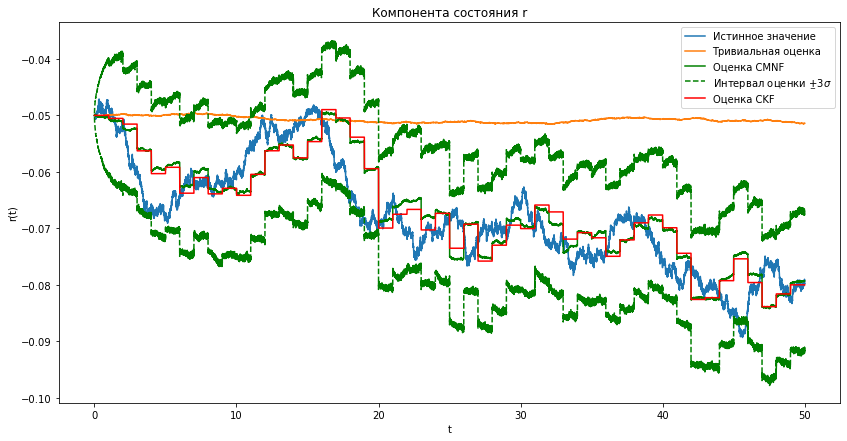

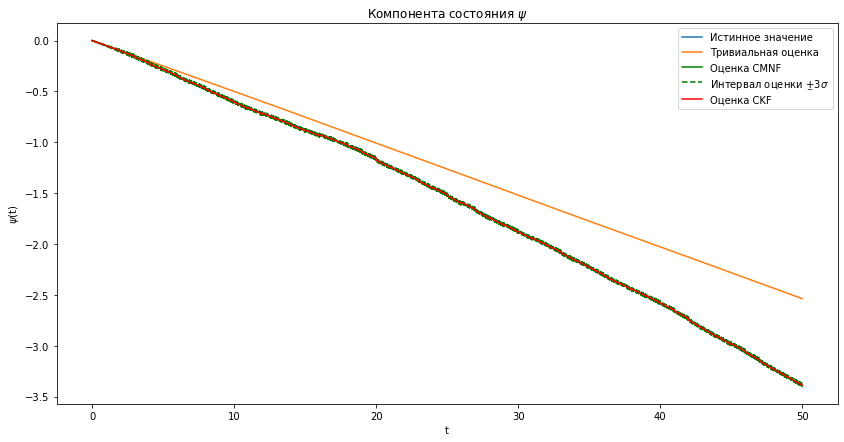

In [81]:
for i in range(6):
    plt.plot(net, X[0, :, i], label = "Истинное значение")
    plt.plot(net, np.mean(X[:,:,i], axis = 0), label = 'Тривиальная оценка')
    plt.title( "Компонента состояния " + labels[i])
    plt.plot(net, X_res_cmnf[0, :, i], label = "Оценка CMNF", color = 'green')
    plt.plot(net, X_res_cmnf[0,:,i] - 3 * np.sqrt(K_res_cmnf[0,:,i,i]),ls = 'dashed', label = r"Интервал оценки $\underset{-}{+} 3\sigma$", color = 'green')
    plt.plot(net, X_res_cmnf[0, :,i] + 3 * np.sqrt(K_res_cmnf[0,:,i,i]),ls = 'dashed', color = 'green')
    plt.plot(net, X_res_ckf[0, :, i], label = "Оценка CKF", color = 'red')
    plt.ylabel(labels[i] + "(t)")
    plt.xlabel("t")
    plt.legend()
    plt.show()

Теперь выведем выборочные СКО тривиальной оценки и оценок, полученных с помощью фильтров.

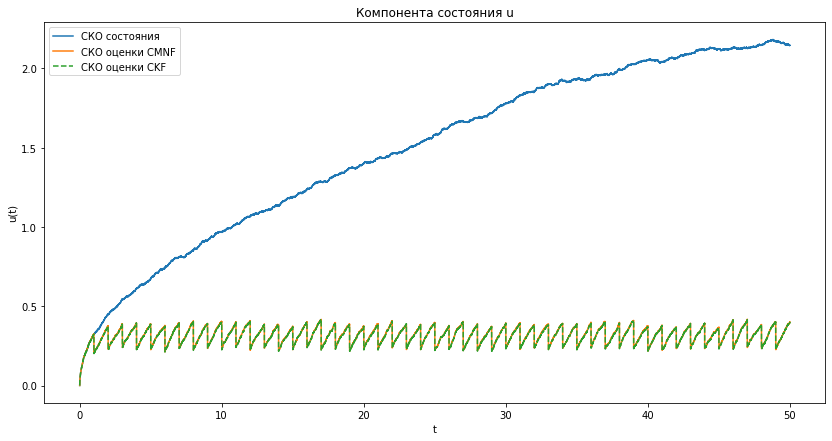

False


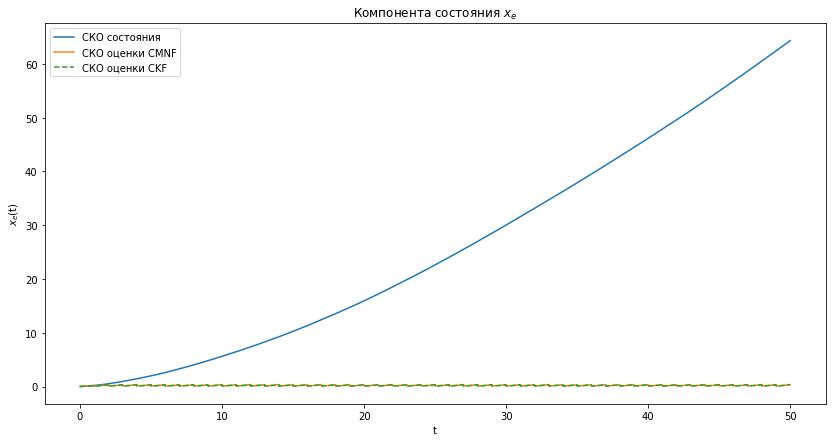

False


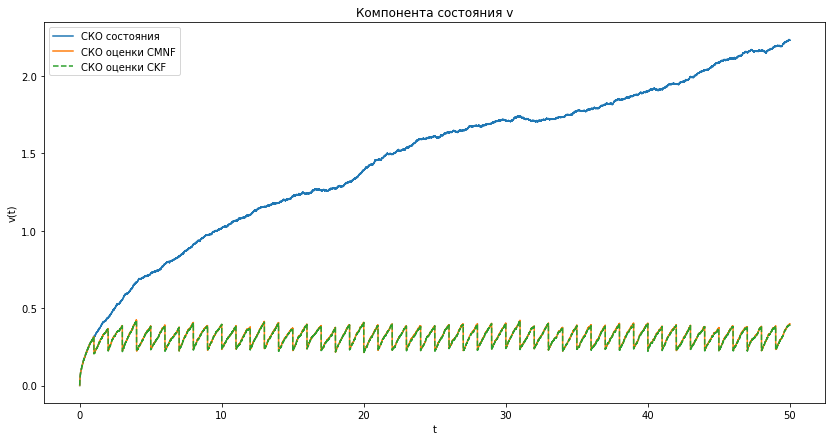

False


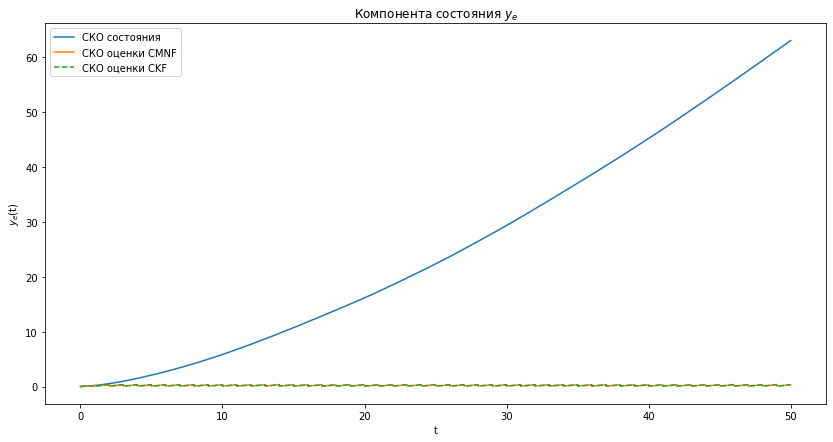

False


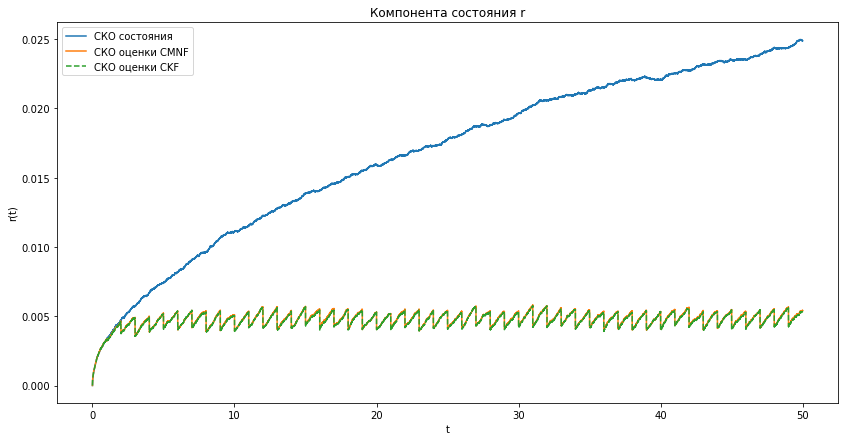

False


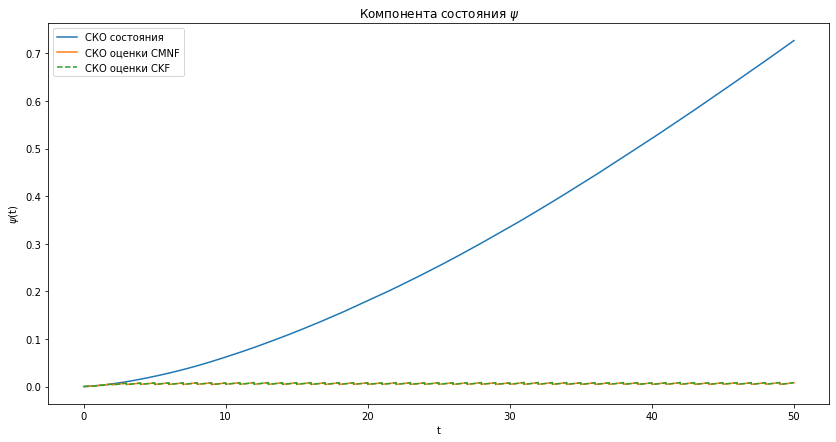

False


In [82]:
for i in range(6):
    plt.plot(net, np.std(X[:,:,i], axis = 0), label = "СКО состояния")
    plt.plot(net, np.std((X_res_cmnf-X)[:,:,i], axis = 0), label = "СКО оценки CMNF")
    plt.plot(net, np.std((X_res_ckf-X)[:,:,i], axis = 0), label = "СКО оценки CKF",  ls = 'dashed')
    plt.ylabel(labels[i] + "(t)")
    plt.xlabel("t")
    plt.title( "Компонента состояния " + labels[i])
    plt.legend()
    plt.show()
    print(np.allclose(np.std((X_res_cmnf-X)[:,:,i], axis = 0), np.std((X_res_ckf-X)[:,:,i], axis = 0)))

## Вывод

Как можно заметить, фильтры CKF и CMNF практически идентичны с точки зрения СКО оценки, но на деле же их оценки в случае различаются, хоть и не сильно, однако оценка с помощью CMNF демонстрирует большую схожесть с "зашумленной" структурой фильтруемого состояния, тогда как фильтр CKF является более ступенчато-гладким. 
Вполне логично можно заметить, что менее точным образом предсказываются компоненты $u,v,r$, которые не наблюдаются и являются зашумленными, однако и среди них закономерно компонента $r$ предсказывается с самым большим интервалом $3\sigma$, поскольку, исходя из системы, ее изменение осуществляется исключительно за счет стороннего шума, тогда как в уравнении динамики для компонент $v,u$ участвует наблюдаемая компонента состояния $\psi$, что позволяет фильтрам более точно оценивать их структуру.

Вероятно, при большем количестве времени или иных предположениях о зашумлении фильтры проявят себя иначе, однако при оценке в заданных условиях
